In [1]:
import numpy as np
import pandas as pd
# import umap
import umap.umap_ as umap
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import product
from sklearn.pipeline import Pipeline
from   sklearn.manifold import TSNE
from   sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
seed = 0

# PCA

- Finds directions that maximize variance
- These directions that are mutually orthogonal
- The first component has the highest variance
- The variation present in the PCs decrease as we move from the 1st PC to the last one
- The PCs are linear combinations of the original variables/basis.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

transformer = TfidfVectorizer(sublinear_tf = True, min_df = 0.05, max_df = 0.90, strip_accents='unicode', stop_words='english')

df = pd.read_csv("Reviews_sample.csv")
# Train/test split [ /2 marks]

X = df['text']
y = df['label']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = seed)

# Calculate the Tf-Idf transform on training and test [ /4 marks]
XtrainTransform = transformer.fit_transform(Xtrain).toarray()
XtestTransform = transformer.transform(Xtest).toarray()

In [3]:
pca = PCA(n_components=2)
pca.fit(XtrainTransform)
Z1 = pca.transform(XtestTransform)
# Get the results
sns.scatterplot(x=Z1[:, 0], y=Z1[:, 1], hue=ytest)

# Create plot
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA of Amazon Rewiews")
plt.show()

# Sparse PCA

Sparsity is enforced most of the time on the principal loadings _i.e.,_ $\boldsymbol V$. The advantage of sparsity is that a sparse $\boldsymbol V$ tells us which variables from the original $p$-dimensional feature space are worth keeping. This helps with interpretability.

Sparsity can also be enforced on the entries of $\boldsymbol Z$, but that's far less popular.

In [ ]:
sPCA = SparsePCA(n_components=2, random_state=0, alpha=0.5) # play with alpha to control sparsity 
sPCA.fit(XtrainTransform)

# Get the results
Z2 = sPCA.transform(XtrainTransform)  # This are the the Z  

# Create plot
sns.scatterplot(x=Z1[:, 0], y=Z1[:, 1], hue=ytest)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA of Amazon Rewiews")
plt.show()

# T-sne

Some parameters in TSNE are extremely important. [This](https://distill.pub/2016/misread-tsne/) is a great paper going into detail in this regard.

In particular:

- Perplexity: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. In general, set to a high value and test a few.
- n_iter: The method must converge to be good. Set high and let the min_grad_norm and n_iter_without_progress stop the training.
- Metric: How to measure distances. Can be any keyword [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html). For text, cosine similarity is [known to work](https://academic.oup.com/bioinformatics/article/22/18/2298/318080).

In [ ]:
tSNEmapper = TSNE(n_components=2,               # How many dimensions to use. Never more than 2 or 3
                  init='random',                # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
                  perplexity=100.0,              # Read below
                  early_exaggeration=12.0,      # Read below
                  learning_rate='auto',         # Related to above. Leave to auto
                  n_iter=5000,                  # Very important to let iterate enough
                  n_iter_without_progress=300,  # Set early stopping
                  metric='euclidean',           # Metric to use to calculate distances.
                  min_grad_norm=1e-7,           # Minimum gradient to continue iterating
                  verbose=0,                    # Verbosity
                  random_state=42,              # Random seed
                  n_jobs=4,                     # Parallel processes
                  square_distances=True         # Square or root distances?
                 )

# UMAP

UMAP (Uniform Manifold Approximation and Projection) is a more sophisticated model based on solid mathematical principles. They are fairly sophisticated.

UMAP is far more efficient than t-SNE, particularly when projecting into more than two dimensions, so it is generally a better method than t-SNE. It is, however, still not very mainstream.

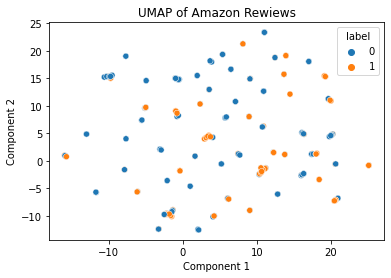

In [5]:
reducer = umap.UMAP(n_neighbors=2,              # Number of neareast neighbours to use. 
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    min_dist = 0.1,
                    metric='hellinger',          # Metric to use.
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    low_memory=True,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    random_state=seed,             # Random seed
                    verbose=False                 # Verbosity
                   )

# Now we train and calculate the embedding!
UMAP_embedding = reducer.fit_transform(XtestTransform)


sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=ytest)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of Amazon Rewiews")
plt.show()

## UMAP on with logistic regression

0.685972850678733


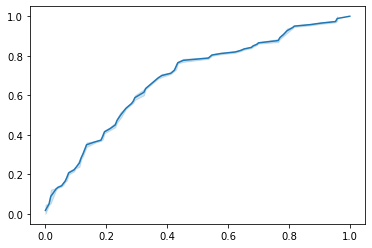

In [6]:
# Apply UMAP first [ / 4 marks]
reducer = umap.UMAP(n_neighbors=2,              # Number of neareast neighbours to use. 
                    n_components=10,              # Number of components. UMAP is robust to larger values
                    min_dist = 0.1,
                    metric='hellinger',          # Metric to use.
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    low_memory=True,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    random_state=seed,             # Random seed
                    verbose=False                 # Verbosity
                   )

# Train and test using model LogisticRegressionCV [ /4 marks]
logReg = LogisticRegressionCV(cv=5)

# Define the model
model = Pipeline([
    ('umap', reducer), 
    ('log', logReg)])

# Fit on the training dataset
model.fit(XtrainTransform, ytrain)

# Apply to the test dataset
ypred = model.predict(XtestTransform)
ytest_prob3 = model.predict_proba(XtestTransform)

# Plot ROC curve and compute AUC score [ /4 marks]
# Calculate the ROC curve points and plot
fpr3, tpr3, _ = roc_curve(ytest, ytest_prob3[:,1])
sns.lineplot(x = fpr3, y = tpr3)

# Calculate the AUC and print it
AUC3 = roc_auc_score(ytest, ytest_prob3[:,1])
print(AUC3)